<a href="https://colab.research.google.com/github/Aadityesha/PlantDiseaseDetection/blob/main/Potato_Disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the required libraries

In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

Load data into tf.dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/Potato Disease Classification",
  shuffle=True,
  image_size = (IMAGE_SIZE,IMAGE_SIZE),
  batch_size = BATCH_SIZE
) 

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 0 1 0 1 1 1 1 1 2 1 1 1 1 2 1 0 0 2 0 1 1 0 1 0 1 1 1 1 0 1]


Data visualization

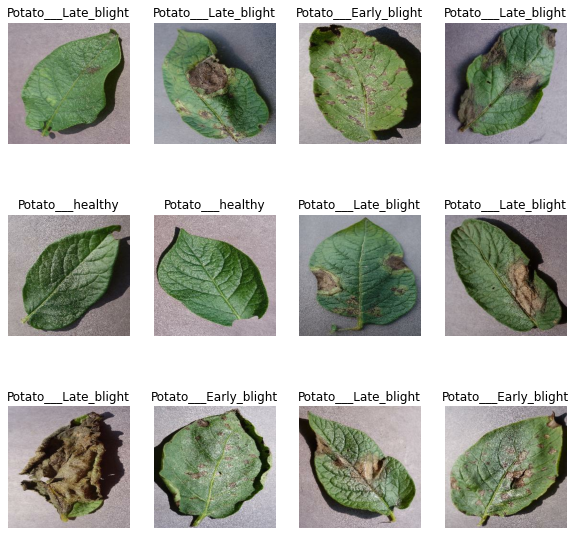

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

### Divide the data into train-test-validation split
I've used train:test:validation = 80:10:10

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
val_size = 0.1
test_size = 0.1
print(len(dataset)*train_size)
print(len(dataset)*val_size)
print(len(dataset)*test_size)

54.400000000000006
6.800000000000001
6.800000000000001


In [9]:
train_ds = dataset.take(54)
rest_ds = dataset.skip(54)
val_ds = rest_ds.take(6)
test_size = rest_ds.skip(6)

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split = 0.1, shuffle=True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)
  
  train_ds = ds.take(train_size)
  rest_ds = ds.skip(train_size)
  val_ds = rest_ds.take(val_size)
  test_ds = rest_ds.skip(val_size)

  return train_ds, val_ds, test_size

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Data augmentation

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Build and train a CNN model

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 158s 441ms/step - loss: 0.8699 - accuracy: 0.5353 - val_loss: 0.7839 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 18s 334ms/step - loss: 0.5844 - accuracy: 0.7309 - val_loss: 0.5544 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 18s 338ms/step - loss: 0.4027 - accuracy: 0.8316 - val_loss: 0.3344 - val_accuracy: 0.8854
Epoch 4/50
54/54 [==============================] - 18s 332ms/step - loss: 0.2729 - accuracy: 0.8866 - val_loss: 0.2381 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 18s 331ms/step - loss: 0.2583 - accuracy: 0.8953 - val_loss: 0.1868 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 18s 337ms/step - loss: 0.2121 - accuracy: 0.9115 - val_loss: 0.1131 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 18s 333ms/step - loss: 0.1350 - accuracy: 0.9462 - val_loss: 0.4347 - val_accuracy: 0.859

In [20]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 57ms/step - loss: 0.0307 - accuracy: 0.9828


Plot training history on graph

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

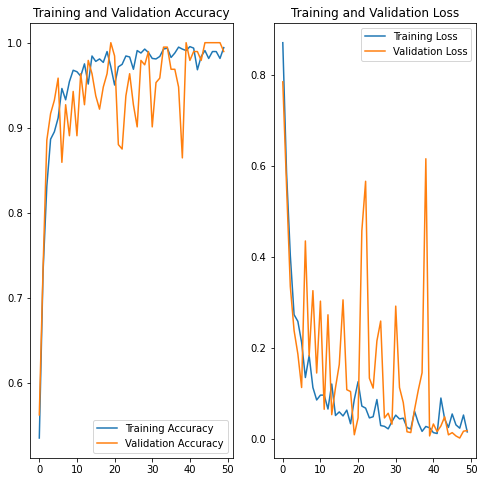

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Make predictions on sample images using our architecture

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


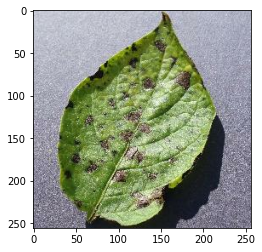

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

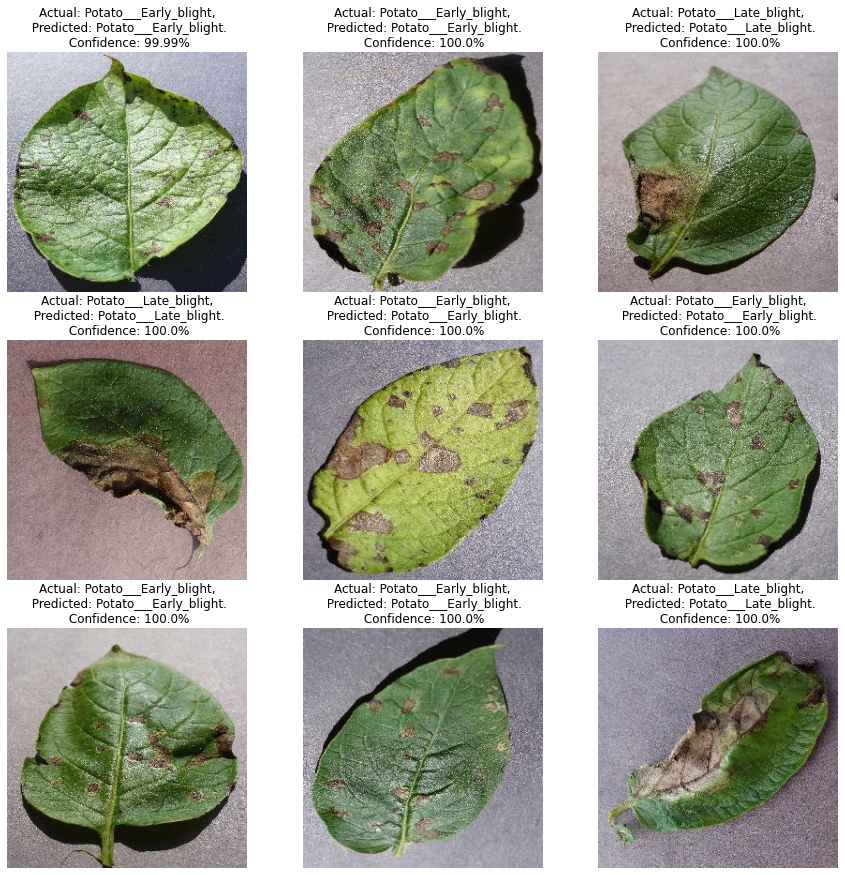

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
